# Machine Learning Project

- Competition: [Kaggle](https://www.kaggle.com/c/to-loan-or-not-to-loan-that-is-the-question-ac2122/leaderboard)

In [1]:
# configuring pandas
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 40)

In [2]:
# Utilitary functions
from datetime import date

# Format: YYMMDD -> Year is before 2000
def parse_date(d):
    year = int(str(d)[0:2])
    month = int(str(d)[2:4])
    day = int(str(d)[4:6])
    return year, month, day

def calculate_age(year, month, day):
    today = date.today()
    return today.year - year - ((today.month, today.day) < (month, day))

def parse_client_dates(df):
    ages = []
    genders = []
    birthdates = []

    for birth_number in df["birth_number"]:
        year = int(str(birth_number)[0:2])
        month = int(str(birth_number)[2:4])
        day = int(str(birth_number)[4:6])
        # check if the client is female or male
        if month > 12:
            genders.append("F")  # female
            month = month - 50
        else:
            genders.append("M")  # male
        
        year = year + 1900

        ages.append(calculate_age(year, month, day))
        birthdates.append("%s-%s-%s" % (year, month, day))

    # Add the new columns to the dataframe
    df["client_age"] = ages
    df["client_gender"] = genders
    df["birthdate"] = birthdates
    df["birthdate"] = pd.to_datetime(df['birthdate'], format='%Y-%m-%d')

    # Drop the unnecessary column
    df = df.drop(columns="birth_number", axis=1)
    return df

In [3]:
def prep_loans(data_type):
    # process loans data
    df = pd.read_csv("data/loan_" + data_type + ".csv", sep=";", parse_dates=["date"])
    df.rename(columns={'date': 'loan_date','amount':'loan_amount'}, inplace=True)

    return df

In [4]:
from numpy import array
from sklearn.preprocessing import LabelEncoder

def prep_accounts():
    # Add the account data
    df = pd.read_csv("data/account.csv", sep=";", parse_dates=["date"])

    df.rename(columns={"date": "account_date", "district_id": "account_district_id"}, inplace=True)
    
    return df

In [5]:
def prep_dispositions():
     # to join the dispositions table we could count, for each account, the number of disponents
    dispositions_df = pd.read_csv("data/disp.csv", sep=";")
    dispositions_df.rename(columns={"client_id": "disp_client_id", "type": "disp_type"}, inplace=True)

    return dispositions_df

In [6]:
def prep_owners():
    # to join the dispositions table we could count, for each account, the number of disponents
    dispositions_df = pd.read_csv("data/disp.csv", sep=";")
    # disponents = dispositions_df.groupby('account_id')["type"].count().reset_index(name='account_clients')
    # add the owner id
    owners = dispositions_df[dispositions_df.type == "OWNER"][["account_id", "client_id"]].rename(columns={"client_id": "owner_id"})

    return owners

In [7]:
def prep_clients():
    # join clients data
    clients_df = pd.read_csv("data/client.csv", sep=";")
    clients_df = parse_client_dates(clients_df).rename(columns={"client_id": "owner_id", "district_id": "owner_district_id"})

    return clients_df

In [8]:
def prep_demographic(prefix):
    demographic_df = pd.read_csv("data/district.csv", sep=";")
    demographic_df = demographic_df.rename(columns=lambda x: x.strip())    
    demographic_df = demographic_df.rename(columns=lambda x: x.replace("'", ""))   
    
    demographic_df = demographic_df.drop(columns="name", axis=1)

    demographic_df["unemploymant rate 95"] = np.where(demographic_df["unemploymant rate 95"] == '?', demographic_df["unemploymant rate 96"], demographic_df["unemploymant rate 95"])
    demographic_df["no. of commited crimes 95"] = np.where(demographic_df["no. of commited crimes 95"] == '?', demographic_df["no. of commited crimes 96"], demographic_df["no. of commited crimes 95"])

    demographic_df = demographic_df.rename(columns={"code": "district_id"})

    return demographic_df.rename(columns=lambda x: prefix + x) 

In [9]:
def prep_transactions(data_type):
    df = pd.read_csv("data/trans_" + data_type + ".csv", sep=";", parse_dates=["date"], low_memory=False)
    
    df.loc[df["operation"].isna(),"operation"] = df.loc[df["operation"].isna(), "k_symbol"]

    df.loc[df["type"] == "withdrawal in cash", "type"] = "withdrawal"
    df.loc[df["type"] == "withdrawal", "amount"] *=-1 

    df = df.drop(['bank', 'account', 'k_symbol'], axis=1)
    
    df.rename(columns={"date": "transaction_date"}, inplace=True)

    return df

In [10]:
def prep_cards(data_type):
    df = pd.read_csv("data/card_" + data_type + ".csv", sep=";", parse_dates=["issued"])

    return df.rename(columns={"type": "card_type", "issued": "card_issued"})

# Data Analysis

- Identify possible outliers on each set

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

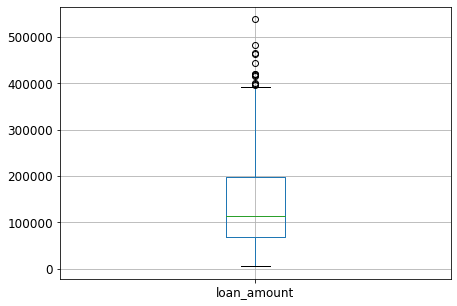

In [12]:
loans_df = prep_loans("train")

loans_df.boxplot(column=['loan_amount'], fontsize=12, figsize=(7, 5))


<AxesSubplot:>

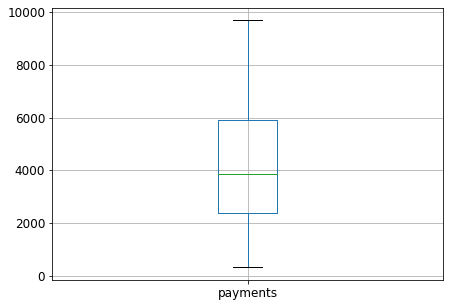

In [13]:
loans_df.boxplot(column=['payments'], fontsize=12, figsize=(7, 5))

<AxesSubplot:xlabel='status', ylabel='count'>

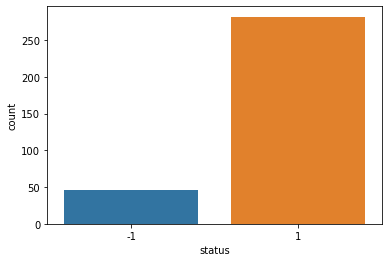

In [14]:
sns.countplot(x="status",data=loans_df)

<AxesSubplot:xlabel='type', ylabel='count'>

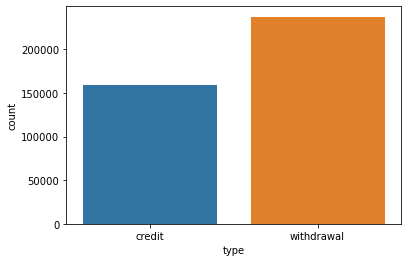

In [15]:
transactions_df = prep_transactions("train")

sns.countplot(x="type",data=transactions_df)

<AxesSubplot:xlabel='amount'>

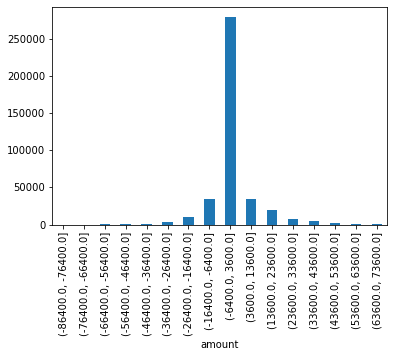

In [16]:
min_amount = transactions_df["amount"].min()
max_amount = transactions_df["amount"].max()

data = transactions_df.groupby(pd.cut(transactions_df["amount"], np.arange(min_amount, max_amount, 10000))).count()[
        "trans_id"]

data.plot.bar()

<AxesSubplot:xlabel='amount'>

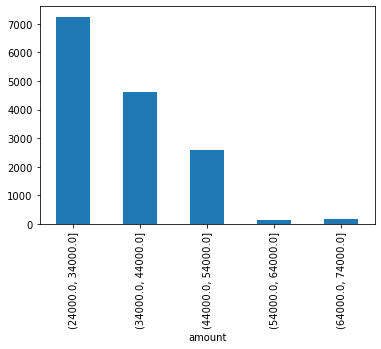

In [17]:
data = transactions_df.groupby(pd.cut(transactions_df["amount"], np.arange(24000, max_amount, 10000))).count()[
        "trans_id"]

data.plot.bar()

<AxesSubplot:xlabel='amount'>

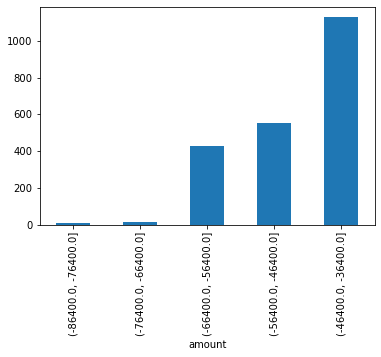

In [18]:
data = transactions_df.groupby(pd.cut(transactions_df["amount"], np.arange(min_amount, -36000, 10000))).count()[
        "trans_id"]

data.plot.bar()

<AxesSubplot:>

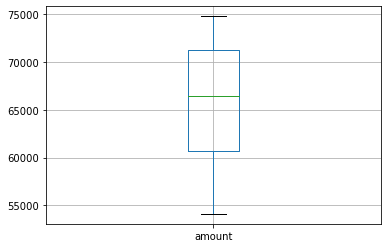

In [19]:
data = transactions_df[transactions_df["amount"] > 54000]

data.boxplot(column=["amount"])

<AxesSubplot:>

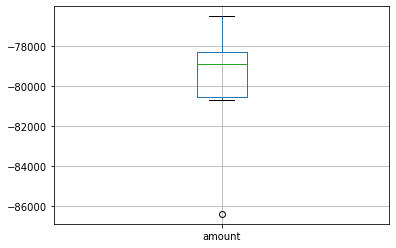

In [20]:
data = transactions_df[transactions_df["amount"] < -76400]

data.boxplot(column=["amount"])

In [21]:
data = transactions_df[transactions_df["amount"] == transactions_df["amount"].min()]

data

,trans_id,account_id,transaction_date,type,operation,amount,balance
303907,855512,2915,1996-06-14,withdrawal,withdrawal in cash,-86400.0,29421.5


We've found one possible outlier, the account with ID 2915 withdrew 86400 credits which is the highest value operation so far for withdrawals. We will take a closer look at this value once we have the bigger picture.

In [22]:
def read_prep_data(data_type):
    # Read and process data
    loans_df = prep_loans(data_type)
    accounts_df = prep_accounts()
    owners_df = prep_owners()
    clients_df = prep_clients()
    owner_districts_df = prep_demographic("owner_")
    # account_districts_df = prep_demographic("account_")
    transactions_df = prep_transactions(data_type)

    df = pd.merge(loans_df, owners_df, on="account_id")
    df = pd.merge(df, clients_df, on="owner_id")
    df = pd.merge(df, accounts_df, on="account_id")
    df = pd.merge(df, transactions_df, on="account_id")
    df = pd.merge(df, owner_districts_df, on="owner_district_id")

    return df

In [23]:
# Methods for aggregation
def age_days(x):
    return (x.max()-x.min()).days

def abs_min(x):
    return x.abs().min()
def rangev(x):
    return x.max() - x.min()

def count_out(x):
    return sum(x=="withdrawal")
def count_in(x):
    return sum(x=="credit")

def mean_out(x):
    return np.mean(x=="withdrawal")
def mean_in(x):
    return np.mean(x=="credit")

def cov_out(x):
    return np.cov(x=="withdrawal")
def cov_in(x):
    return np.cov(x=="credit")

def std_in(x):
    return np.std(x=="credit")
def std_out(x):
    return np.std(x=="withdrawal")


def count_classic(x):
    return sum(x == "classic")
def count_junior(x):
    return sum(x == "junior")
def count_gold(x):
    return sum(x == "gold")

In [24]:
# Data Aggregation
def aggregate_transaction_data(df):
    new_columns = ["loan_id", "account_id", "status", "loan_date", 
                "loan_amount", "duration", "payments", 
                "owner_district_id", "client_age",
                "client_gender", "account_district_id", "frequency",
                "account_date", "birthdate"]

    # need to add covariances somehow
    df = df.groupby(new_columns, as_index=False, group_keys=False).agg({
        "transaction_date" : ["max", "min"],
        "operation": ["count"],
        "amount": ["mean","min","max","std","last", abs_min, rangev],
        "balance": ["mean","min","max","std","last", abs_min, rangev],
        "type": [count_in, count_out, mean_in, mean_out]
    })
    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]
    
    # retreive some interesting data such as the client's age when the loan was issued

    return df

In [25]:
def aggregate_cards_data(data_type, df):
    df = pd.merge(df, prep_dispositions(), on="account_id", how="left")
    df = pd.merge(df, prep_cards(data_type), on="disp_id", how="left")

    new_columns = [x for x in list(df) if x not in ["card_id", "card_type", "disp_id", "disp_type", "disp_client_id", "card_issued"]]

    df = df.groupby(new_columns, as_index=False, group_keys=False).agg({
        "disp_id": ["count"],
        "card_type": [count_gold, count_classic, count_junior]
    })
    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]

    return df

In [26]:
# Process Dates (dates need to be addressed later, they are lowering the prediction score)

def process_dates(df):
    df["loan_year"] = df["loan_date"].map(lambda x: x.year)
    df["account_year"] = df["account_date"].map(lambda x: x.year)
    df["transaction_year_max"] = df["transaction_date_max"].map(lambda x: x.year)
    df["transaction_year_min"] = df["transaction_date_min"].map(lambda x: x.year)
    
    return df.drop(['loan_date'], axis=1)

In [27]:
def aggregate_demographic_data(df, prefix):
    demographic_columns = ["district_id", "region", "no. of inhabitants",
                "no. of municipalities with inhabitants < 499",
                "no. of municipalities with inhabitants 500-1999",
                "no. of municipalities with inhabitants 2000-9999",
                "no. of municipalities with inhabitants >10000",
                "no. of cities", "ratio of urban inhabitants",
                "average salary", "unemploymant rate 95", 
                "unemploymant rate 96",
                "no. of enterpreneurs per 1000 inhabitants", 
                "no. of commited crimes 95", "no. of commited crimes 96"]
    
    # for now
    to_ignore = ["region"]

    demographic_df = prep_demographic(prefix)
    

    return pd.merge(df, demographic_df[["{0}{1}".format(prefix, x) for x in demographic_columns if x not in to_ignore]], on="{0}district_id".format(prefix))
    

## Read Data and Process Aggregations

In [28]:
from dateutil.relativedelta import relativedelta

# Train pipeline
train_df = read_prep_data("train")

In [29]:
train_df = aggregate_transaction_data(train_df)
train_df = aggregate_cards_data("train", train_df)

### Process last transactions before loan issue

In [30]:
def process_last_transactions(data_type, df):
    last_transactions = pd.DataFrame()
    
    transactions_df = prep_transactions(data_type)
    
    for index, row in df.iterrows():
        data = transactions_df[transactions_df["account_id"] == row["account_id"]]
        data = data[data["transaction_date"] < row["loan_date"]]
        data = data.sort_values(by=['transaction_date'], ascending=False)
        data = data.iloc[:1]

        data = data.rename(columns=lambda x: "before_loan_" + x)
        data = data.rename(columns={"before_loan_account_id": "account_id"})
        last_transactions = last_transactions.append(data, ignore_index=True)
    last_transactions = last_transactions.drop(["before_loan_trans_id", "before_loan_type", "before_loan_operation"], axis=1)
    
    return pd.merge(df, last_transactions, on="account_id")
    
train_df = process_last_transactions("train", train_df)
    

### Adding relevant features for the problem

<AxesSubplot:>

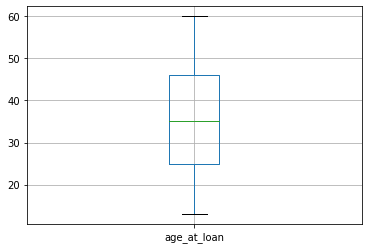

In [31]:
def process_loan_age(df):
    df['age_at_loan'] = df.apply(lambda x: relativedelta(x["loan_date"], x["birthdate"]).years, axis=1)
    return df

train_df = process_loan_age(train_df)

train_df.boxplot(column=["age_at_loan"])

<AxesSubplot:xlabel='underage', ylabel='count'>

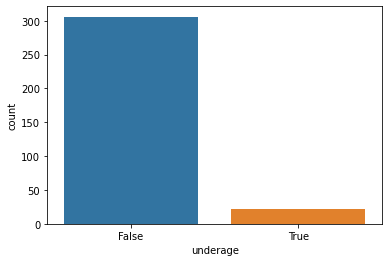

In [32]:
def process_underage_loan(df):
    df["underage"] = df.apply(lambda x: x["age_at_loan"] < 18, axis=1)
    return df

train_df = process_underage_loan(train_df)
    
sns.countplot(x="underage",data=train_df)

### Wrap-Up data and Sort by Loan Data

In [33]:
train_df.loc[train_df["status"] == 1, "status"] = "no"
train_df.loc[train_df["status"] == -1, "status"] = "yes"

train_df = aggregate_demographic_data(train_df, "account_")
train_df = aggregate_demographic_data(train_df, "owner_")

# we should sort by loan data to have a realistic train/test split while training
train_df.sort_values(by=['loan_date'], inplace=True)
train_df = train_df.reset_index(drop=True)

train_df.to_csv("train.csv", index=False)

print("Train data")
train_df

Train data


,loan_id,account_id,status,loan_date,loan_amount,duration,payments,owner_district_id,client_age,client_gender,account_district_id,frequency,account_date,birthdate,transaction_date_max,transaction_date_min,operation_count,amount_mean,amount_min,amount_max,amount_std,amount_last,amount_abs_min,amount_rangev,balance_mean,balance_min,balance_max,balance_std,balance_last,balance_abs_min,balance_rangev,type_count_in,type_count_out,type_mean_in,type_mean_out,disp_id_count,card_type_count_gold,card_type_count_classic,card_type_count_junior,before_loan_transaction_date,before_loan_amount,before_loan_balance,age_at_loan,underage,account_no. of inhabitants,account_no. of municipalities with inhabitants < 499,account_no. of municipalities with inhabitants 500-1999,account_no. of municipalities with inhabitants 2000-9999,account_no. of municipalities with inhabitants >10000,account_no. of cities,account_ratio of urban inhabitants,account_average salary,account_unemploymant rate 95,account_unemploymant rate 96,account_no. of enterpreneurs per 1000 inhabitants,account_no. of commited crimes 95,account_no. of commited crimes 96,owner_no. of inhabitants,owner_no. of municipalities with inhabitants < 499,owner_no. of municipalities with inhabitants 500-1999,owner_no. of municipalities with inhabitants 2000-9999,owner_no. of municipalities with inhabitants >10000,owner_no. of cities,owner_ratio of urban inhabitants,owner_average salary,owner_unemploymant rate 95,owner_unemploymant rate 96,owner_no. of enterpreneurs per 1000 inhabitants,owner_no. of commited crimes 95,owner_no. of commited crimes 96
0,5314,1787,yes,1993-07-05,96396,12,8033,30,74,F,30,weekly issuance,1993-03-22,1947-07-22,1993-06-20,1993-03-22,4,5025.000000,1100.0,9900.0,3774.806838,3300.0,1100.0,8800.0,12250.000000,1100.0,20100.0,8330.866301,20100.0,1100.0,19000.0,4,0,1.000000,0.000000,1,0,0,0,1993-06-20,3300.0,20100.0,45,False,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985,2804,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
1,5316,1801,no,1993-07-11,165960,36,4610,46,53,M,46,monthly issuance,1993-02-13,1968-07-22,1993-07-09,1993-02-13,37,1411.051351,-54300.0,36574.0,17882.999059,-3419.0,2.9,90874.0,52083.859459,700.0,120512.8,29122.059454,52208.9,700.0,119812.8,17,20,0.459459,0.540541,1,0,0,0,1993-07-09,-3419.0,52208.9,24,False,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854,2618,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854,2618
2,6863,9188,no,1993-07-28,127080,60,2118,45,85,M,45,monthly issuance,1993-02-08,1936-06-02,1993-07-21,1993-02-08,24,844.708333,-14800.0,19065.0,8272.421583,-12000.0,48.6,33865.0,30060.954167,800.0,49590.4,11520.184451,20272.8,800.0,48790.4,15,9,0.625000,0.375000,1,0,0,0,1993-07-21,-12000.0,20272.8,57,False,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080,2122,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080,2122
3,5325,1843,no,1993-08-03,105804,36,2939,14,81,F,12,monthly issuance,1993-01-30,1940-04-20,1993-07-31,1993-01-30,25,1371.704000,-15600.0,26448.0,11376.124631,-14.6,14.6,42048.0,41297.480000,1000.0,65898.5,14151.260443,34292.7,1000.0,64898.5,13,12,0.520000,0.480000,1,0,0,0,1993-07-31,-14.6,34292.7,53,False,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137,3804,3868,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604,6295
4,7240,11013,no,1993-09-06,274740,60,4579,63,43,M,1,weekly issuance,1993-02-14,1978-09-07,1993-08-31,1993-02-14,27,1522.707407,-36700.0,63366.0,27294.178010,182.8,30.0,100066.0,57188.211111,600.0,122893.1,25256.665817,41142.9,600.0,122293.1,13,14,0.481481,0.518519,1,0,0,0,1993-08-31,182.8,41142.9,14,True,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562,1460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,no,1996-12-12,155616,48,3242,

Looking for the Account ID 2915, there was no matching record, so the possible outlier on the transactions dataframe is irrelevant since the data is aggregated.

In [34]:
# Test Pipeline
test_df = read_prep_data("test")

test_df.status = test_df.status.fillna('')
test_df = aggregate_transaction_data(test_df)
test_df = aggregate_cards_data("test", test_df)
test_df = process_last_transactions("test", test_df)
test_df = process_loan_age(test_df)
test_df = process_underage_loan(test_df)
test_df = aggregate_demographic_data(test_df, "account_")
test_df = aggregate_demographic_data(test_df, "owner_")

test_df.to_csv("test.csv", index=False)

print("Test Data")
test_df


Test Data


,loan_id,account_id,status,loan_date,loan_amount,duration,payments,owner_district_id,client_age,client_gender,account_district_id,frequency,account_date,birthdate,transaction_date_max,transaction_date_min,operation_count,amount_mean,amount_min,amount_max,amount_std,amount_last,amount_abs_min,amount_rangev,balance_mean,balance_min,balance_max,balance_std,balance_last,balance_abs_min,balance_rangev,type_count_in,type_count_out,type_mean_in,type_mean_out,disp_id_count,card_type_count_gold,card_type_count_classic,card_type_count_junior,before_loan_transaction_date,before_loan_amount,before_loan_balance,age_at_loan,underage,account_no. of inhabitants,account_no. of municipalities with inhabitants < 499,account_no. of municipalities with inhabitants 500-1999,account_no. of municipalities with inhabitants 2000-9999,account_no. of municipalities with inhabitants >10000,account_no. of cities,account_ratio of urban inhabitants,account_average salary,account_unemploymant rate 95,account_unemploymant rate 96,account_no. of enterpreneurs per 1000 inhabitants,account_no. of commited crimes 95,account_no. of commited crimes 96,owner_no. of inhabitants,owner_no. of municipalities with inhabitants < 499,owner_no. of municipalities with inhabitants 500-1999,owner_no. of municipalities with inhabitants 2000-9999,owner_no. of municipalities with inhabitants >10000,owner_no. of cities,owner_ratio of urban inhabitants,owner_average salary,owner_unemploymant rate 95,owner_unemploymant rate 96,owner_no. of enterpreneurs per 1000 inhabitants,owner_no. of commited crimes 95,owner_no. of commited crimes 96
0,4962,25,,1997-12-08,30276,12,2523,68,59,M,68,monthly issuance,1996-07-28,1962-02-09,1997-12-06,1996-07-28,164,192.816463,-62900.0,49734.0,19772.510052,-1110.0,14.6,112634.0,62991.264634,900.0,119652.7,22476.347980,31621.9,900.0,118752.7,51,113,0.310976,0.689024,1,0,0,0,1997-12-06,-1110.0,31621.9,35,False,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887
1,5051,378,,1997-10-11,230400,60,3840,68,60,M,68,monthly issuance,1996-07-22,1961-07-24,1997-10-07,1996-07-22,168,293.317262,-59900.0,48038.0,20263.281371,-4.0,2.0,107938.0,79500.538095,20574.0,145352.1,22324.051660,49277.3,20574.0,124778.1,53,115,0.315476,0.684524,1,0,0,0,1997-10-07,-4.0,49277.3,36,False,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887
2,5207,1244,,1997-02-28,35904,48,748,68,75,M,68,monthly issuance,1996-05-08,1946-01-22,1997-02-19,1996-05-08,59,299.361017,-7200.0,7842.0,3026.826901,-600.0,14.6,15042.0,22981.055932,900.0,34278.5,6022.073346,17662.3,900.0,33378.5,24,35,0.406780,0.593220,1,0,0,0,1997-02-19,-600.0,17662.3,51,False,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887
3,5561,2910,,1998-08-29,437460,60,7291,68,68,F,68,monthly issuance,1997-10-21,1953-06-24,1998-08-20,1997-10-21,53,641.798113,-44500.0,65622.0,26560.241912,-1800.0,14.6,110122.0,48935.435849,900.0,101929.2,24396.939772,34015.2,900.0,101029.2,20,33,0.377358,0.622642,1,0,0,0,1998-08-20,-1800.0,34015.2,45,False,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887
4,5906,4533,,1998-05-05,81144,36,2254,68,77,F,68,monthly issuance,1997-08-03,1944-05-27,1998-04-30,1997-08-03,51,1290.200000,-62500.0,48449.0,25868.104611,290.1,14.6,110949.0,67815.174510,200.0,127543.0,26169.159053,90314.9,200.0,127343.0,26,25,0.509804,0.490196,1,0,0,0,1998-04-30,290.1,90314.9,53,False,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,7242,11027,,1997-10-23,48096,24,2004,32,63,M,32,